In [2]:
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import sklearn.metrics
import shutil
import os
import zipfile
import urllib.request
import cv2 as cv
import tqdm
from typing import Optional, Sequence, cast, ClassVar
import scipy.spatial.distance
import skimage.feature

from dataclasses import dataclass
from standalone_preprocessing_library import *

Various constants

In [3]:
DATA_DIR_PATH = "data"
DATASET_PATH = "dataset.zip"
TRAINING_DATA_CSV_PATH = os.path.join(DATA_DIR_PATH, "data.csv")

MODEL_DIR_PATH = "models"
EXPRESSION_RECOGNITION_MODEL_PATH = os.path.join(MODEL_DIR_PATH, "expression_recognition.keras")
LBFMODEL_PATH = os.path.join(MODEL_DIR_PATH, "lbfmodel.yaml")
CASCADE_CLASSIFIER_PATH = os.path.join(MODEL_DIR_PATH, "haarcascade_frontalface_default.xml")

STANDARD_DIMENSIONS = Dimension(240, 240)
FACE_DIMENSIONS = Dimension(120, 120)
PREVIEW_DIMENSIONS = Dimension(500, 500)

LBP_HISTOGRAM_BIN_COUNT = 8
LBP_GRID_SIZE = (8,8)

In [4]:
class SupportedFacialExpressionLabels:
  Ours = ["angry", "disgusted", "happy", "neutral", "sad", "surprised"]
  Fer2013 = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"] 
  CkPlus = ["Anger", "Disgust", "Fear", "Happiness", "Sadness", "Surprise", "Neutral", "Contempt"]

CLASS_NAMES = SupportedFacialExpressionLabels.Ours

Utility functions

In [5]:
def get_files_in_folder(basepath: str)->list[str]:
  if not os.path.exists(basepath):
    return []
  file_paths = [os.path.join(basepath, filename) for filename in os.listdir(basepath)]
  return [path for path in file_paths if os.path.isfile(path)]

def partition_grid(self, rows: int, cols: int)->list["Rectangle"]:
  row_delta = int(self.width / rows)
  col_delta = int(self.height / cols)
  rects: list["Rectangle"] = []
  for row in range(rows):
    for col in range(cols):
      row_start = row * row_delta
      col_start = col * col_delta
      rect = Rectangle(col_start, row_start, col_start + col_delta, row_start + row_delta)
      rects.append(rect)
  return rects

@dataclass
class FaceLandmark:
  face_shape: npt.NDArray
  eyes: npt.NDArray
  eyebrows: npt.NDArray
  nose: npt.NDArray
  lips: npt.NDArray
  dims: Dimension

  @property
  def feature_points(self)->npt.NDArray:
    return np.vstack([self.eyes, self.eyebrows, self.nose, self.lips])

  def as_feature_vector(self)->npt.NDArray:
    # https://arxiv.org/pdf/1812.04510
    # 17 points are dedicated for the shape of the face, which we don't really need.
    normalized_points = self.feature_points / np.array((self.dims.width, self.dims.height))
    interdistance_map = scipy.spatial.distance.cdist(normalized_points, normalized_points, "euclidean").flatten()
    # All diagonal values are excluded
    excluded_points = np.eye(len(self.feature_points)).flatten() == 1

    # Square the interdistance map to make larger differences more prominent
    interdistance_map = np.power(interdistance_map[~excluded_points], 2)

    # Also calculate the distance to the average point in the face
    average_point = normalized_points.mean(axis=0)
    distances_to_center = scipy.spatial.distance.cdist(np.array([average_point]), normalized_points, "euclidean")[0]

    feature_vector = np.hstack((interdistance_map, distances_to_center))

    return feature_vector


  EYE_COLOR: ClassVar[tuple[int, int, int]] = (0, 0, 255)
  LIP_COLOR: ClassVar[tuple[int, int, int]] = (0, 255, 0)
  NOSE_COLOR: ClassVar[tuple[int, int, int]] = (255, 0, 0)
  FACE_SHAPE_COLOR: ClassVar[tuple[int, int, int]] = (255, 255, 0)
  EYEBROW_COLOR: ClassVar[tuple[int, int, int]] = (0, 255, 255)

  def project_point(self, point: npt.NDArray, rect: Optional[Rectangle] = None)->Sequence[int]:
    if rect is None:
      return cast(Sequence[int], point.astype(np.int32))
    projected_point = point * rect.dimensions.ndarray / self.dims.ndarray
    return cast(Sequence[int], (projected_point + rect.p0.ndarray).astype(np.int32))
  
  def draw_on(self, img: cv.typing.MatLike, *, offset: Optional[Rectangle] = None):
    for point in self.eyes:
      cv.circle(img, self.project_point(point, offset), 1, self.EYE_COLOR, -1)
    for point in self.lips:
      cv.circle(img, self.project_point(point, offset), 1, self.LIP_COLOR, -1)
    for point in self.nose:
      cv.circle(img, self.project_point(point, offset), 1, self.NOSE_COLOR, -1)
    for point in self.face_shape:
      cv.circle(img, self.project_point(point, offset), 1, self.FACE_SHAPE_COLOR, -1)
    for point in self.eyebrows:
      cv.circle(img, self.project_point(point, offset), 1, self.EYEBROW_COLOR, -1)

  @staticmethod
  def from_raw_landmark(points: npt.NDArray, dims: Dimension):
    return FaceLandmark(
      face_shape=points[:17],
      eyebrows=points[17:27],
      nose=points[27:36],
      eyes=points[36:48],
      lips=points[48:],
      dims=dims
    )
  
def face_alignment(img: cv.typing.MatLike, landmark: FaceLandmark):
  # https://pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
  dims = Dimension.from_shape(img.shape)
  desired_left_eye = Point(int(dims.width * 0.22), int(dims.height * 0.25))
  desired_right_eye_x = FACE_DIMENSIONS.width - desired_left_eye.x

  left_eye_avg = landmark.eyes[0:6].mean(axis=0)
  right_eye_avg = landmark.eyes[6:].mean(axis=0)

  delta = right_eye_avg - left_eye_avg
  angle = np.degrees(np.arctan2(delta[1], delta[0]))

  dist = np.sqrt(delta[0] ** 2 + delta[1] ** 2)
  desired_dist = desired_right_eye_x - desired_left_eye.x
  scale = desired_dist / dist

  eyes_center = np.array([left_eye_avg, right_eye_avg]).mean(axis=0)
  rotation_matrix = cv.getRotationMatrix2D(eyes_center, angle, scale)

  translation_x = FACE_DIMENSIONS.width * 0.5
  translation_y = desired_left_eye.y
  rotation_matrix[0, 2] += (translation_x - eyes_center[0])
  rotation_matrix[1, 2] += (translation_y - eyes_center[1])

  img = cv.warpAffine(img, rotation_matrix, FACE_DIMENSIONS.tuple, flags=cv.INTER_CUBIC)

  return img


Load various preprocessing models

In [6]:
# https://medium.com/analytics-vidhya/facial-landmarks-and-face-detection-in-python-with-opencv-73979391f30e
LBFMODEL_URL = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"
if not os.path.exists(LBFMODEL_PATH):
  print(f"Cannot find any LBFmodel installation. Installing from {LBFMODEL_URL} to {LBFMODEL_PATH}")
  urllib.request.urlretrieve(LBFMODEL_URL, LBFMODEL_PATH)
landmark_model = cv.face.createFacemarkLBF()
landmark_model.loadModel(LBFMODEL_PATH)

In [7]:
CASCADE_CLASSIFIER_URL = "https://raw.githubusercontent.com/opencv/opencv/refs/heads/4.x/data/haarcascades/haarcascade_frontalface_default.xml"
if not os.path.exists(CASCADE_CLASSIFIER_PATH):
  urllib.request.urlretrieve(CASCADE_CLASSIFIER_URL, CASCADE_CLASSIFIER_PATH) 
locator_model = cv.CascadeClassifier(CASCADE_CLASSIFIER_PATH)
locator_model.load(CASCADE_CLASSIFIER_PATH)

clahe = cv.createCLAHE(tileGridSize=(8, 8), clipLimit=2.0)

Dump the contents of the zip file into the data folder. You don't have to run this if this has been performed.

In [8]:
if (os.path.exists(DATA_DIR_PATH)):
  shutil.rmtree(DATA_DIR_PATH)
with zipfile.ZipFile(DATASET_PATH, 'r') as zip_ref:
  zip_ref.extractall(DATA_DIR_PATH)

List all folder contents

In [9]:
@dataclass
class TrainDataEntry:
  path: str
  label: int

entries: list[TrainDataEntry] = []
for folder in os.scandir(DATA_DIR_PATH):
  if not folder.is_dir():
    continue
  try:
    expression = CLASS_NAMES.index(folder.name)
  except ValueError:
    print(f"Skipping the inclusion of {folder.name} in the dataset.")
    continue

  entries.extend(map(
    lambda fpath: TrainDataEntry(path=fpath, label=expression),
    get_files_in_folder(folder.path)
  ))

Execute data preprocessing steps for our dataset

In [32]:
skipped = 0
list_data: list[npt.NDArray] = []
list_labels: list[int] = []
for entry in tqdm.tqdm(entries, desc="Building dataset from images"):
  original = cv.imread(entry.path)
  
  # Preprocessing
  img_resized = resize_image(original, STANDARD_DIMENSIONS)
  img_grayscale = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)
  img_clahe = clahe.apply(img_grayscale)

  # Extract face coordinates
  face_coordinates = locator_model.detectMultiScale(img_clahe)
  face_rects = list(Rectangle.from_tuple(coords) for coords in face_coordinates)
  face_rects.sort(key=lambda x: x.area)
  saved_face_rects: list[Rectangle] = []
  # Prevent overlapping face rectangles
  for face_rect_a in face_rects:
    is_overlapping = False
    for face_rect_b in saved_face_rects:
      IOU = face_rect_a.intersection_with_union(face_rect_b)
      if IOU > 0.4:
        is_overlapping = True
        break

    if not is_overlapping:
      saved_face_rects.append(face_rect_a)

  # Get faces from original image
  faces = list(
    img_clahe[pos.slice]
    for pos in face_rects
  )

  features: list[npt.NDArray] = []
  for raw_face_img in faces:
    # Additional preprocessing
    face_resized = cv.resize(raw_face_img, FACE_DIMENSIONS.tuple, interpolation=cv.INTER_CUBIC)
    face_blurred = cv.filter2D(face_resized, -1, GAUSSIAN_3X3_KERNEL)
    face_preprocessed = cv.filter2D(face_blurred, -1, SHARPEN_KERNEL)

    # Get face landmarks
    _, raw_face_landmarks = landmark_model.fit(face_preprocessed, np.array(((0, 0, face_preprocessed.shape[0], face_preprocessed.shape[1]),)))
    face_landmark_points: npt.NDArray = raw_face_landmarks[0][0]
    face_landmark = FaceLandmark(
      face_shape=face_landmark_points[:17],
      eyebrows=face_landmark_points[17:27],
      nose=face_landmark_points[27:36],
      eyes=face_landmark_points[36:48],
      lips=face_landmark_points[48:],
      dims=Dimension.from_shape(face_preprocessed.shape)
    )
    face_dims = Dimension.from_shape(raw_face_img.shape)
    face_landmark = FaceLandmark.from_raw_landmark(face_landmark_points, face_dims)
    face_aligned = face_alignment(face_preprocessed, face_landmark)

    # Split image to grids for LBP
    lbp_grid_rects = partition_grid(face_dims, *LBP_GRID_SIZE)
    histograms: list[npt.NDArray] = []

    # Perform LBP
    lbp_image: npt.NDArray = skimage.feature.local_binary_pattern(face_aligned, 8, 1)
    for lbp_grid_rect in lbp_grid_rects:
      chunk = lbp_image[lbp_grid_rect.slice]

      if chunk.size == 0:
        histograms.append(np.full((LBP_HISTOGRAM_BIN_COUNT,), 0))
        continue
      histograms.append(scipy.ndimage.histogram(chunk, 0, 255, LBP_HISTOGRAM_BIN_COUNT) / chunk.size)

    feature_vector = np.hstack(histograms)
    features.append(feature_vector)

  if len(features) == 0:
    print(f"\nSkipping {entry.path} because no faces were found in the image.")
    skipped += 1
    continue
  list_data.extend(features)
  list_labels.extend([entry.label] * len(features))

print(f"Skipped over {skipped} images because no faces were found in the images.")

data = np.array(list_data)
labels = np.array(list_labels).reshape((-1, 1))
dfdata = np.hstack((labels, data))
df = pd.DataFrame(dfdata, columns=[
  "label",
  *map(lambda idx: f'feature-{idx + 1}', range(data.shape[1])),
])

df.to_csv(TRAINING_DATA_CSV_PATH, index=False)

Building dataset from images:   1%|          | 3/412 [00:00<00:18, 21.82it/s]


Skipping data\angry\20240927_173906.jpg because no faces were found in the image.


Building dataset from images:   2%|▏         | 9/412 [00:00<00:20, 19.65it/s]


Skipping data\angry\20241008_180500.jpg because no faces were found in the image.

Skipping data\angry\20241008_180548.jpg because no faces were found in the image.


Building dataset from images:   4%|▎         | 15/412 [00:00<00:17, 22.96it/s]


Skipping data\angry\20241008_180735.jpg because no faces were found in the image.

Skipping data\angry\20241008_180740.jpg because no faces were found in the image.


Building dataset from images:  13%|█▎        | 55/412 [00:03<00:23, 14.98it/s]


Skipping data\angry\marah_4.jpg because no faces were found in the image.

Skipping data\angry\marah_5.jpg because no faces were found in the image.

Skipping data\angry\marah_7.jpg because no faces were found in the image.


Building dataset from images:  17%|█▋        | 70/412 [00:04<00:17, 19.78it/s]


Skipping data\disgusted\20241008_180238.jpg because no faces were found in the image.


Building dataset from images:  26%|██▌       | 107/412 [00:07<00:23, 13.17it/s]


Skipping data\disgusted\IMG_20241010_213941_9_11zon.jpg because no faces were found in the image.


Building dataset from images:  29%|██▊       | 118/412 [00:07<00:19, 15.07it/s]


Skipping data\disgusted\jijik_7.jpg because no faces were found in the image.


Building dataset from images:  31%|███▏      | 129/412 [00:08<00:15, 18.23it/s]


Skipping data\disgusted\WA_Disgusted_195915-min.jpg because no faces were found in the image.


Building dataset from images:  52%|█████▏    | 213/412 [00:15<00:14, 13.71it/s]


Skipping data\happy\senyum_4.jpg because no faces were found in the image.

Skipping data\happy\senyum_5.jpg because no faces were found in the image.


Building dataset from images:  57%|█████▋    | 235/412 [00:16<00:11, 14.87it/s]


Skipping data\neutral\20240927_173857.jpg because no faces were found in the image.


Building dataset from images:  59%|█████▉    | 243/412 [00:17<00:09, 17.19it/s]


Skipping data\neutral\20241008_181350.jpg because no faces were found in the image.


Building dataset from images:  73%|███████▎  | 302/412 [00:21<00:05, 19.41it/s]


Skipping data\neutral\WhatsApp Image 2024-09-19 at 12.24.47 PM.jpg because no faces were found in the image.


Building dataset from images:  82%|████████▏ | 338/412 [00:23<00:05, 13.13it/s]


Skipping data\sad\sedih_5.jpg because no faces were found in the image.

Skipping data\sad\sedih_7.jpg because no faces were found in the image.


Building dataset from images:  88%|████████▊ | 362/412 [00:25<00:02, 20.60it/s]


Skipping data\surprised\20241008_181307.jpg because no faces were found in the image.


Building dataset from images:  97%|█████████▋| 400/412 [00:27<00:00, 14.51it/s]


Skipping data\surprised\terkejut_4.jpg because no faces were found in the image.

Skipping data\surprised\terkejut_5.jpg because no faces were found in the image.


Building dataset from images: 100%|██████████| 412/412 [00:28<00:00, 14.43it/s]


Skipped over 22 images because no faces were found in the images.


Start training process

In [191]:
df = pd.read_csv(TRAINING_DATA_CSV_PATH, index_col=False)
labels = df["label"]
df = df.drop(columns=["label"])
df

,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,feature-10,...,feature-503,feature-504,feature-505,feature-506,feature-507,feature-508,feature-509,feature-510,feature-511,feature-512
0,0.376731,0.041551,0.016620,0.058172,0.030471,0.000000,0.072022,0.404432,0.479224,0.008310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.408163,0.090703,0.018141,0.083900,0.006803,0.002268,0.081633,0.308390,0.512472,0.036281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.503086,0.089506,0.018519,0.080247,0.015432,0.000000,0.061728,0.231481,0.444444,0.046296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.404959,0.047521,0.020661,0.068182,0.045455,0.004132,0.076446,0.332645,0.438017,0.066116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.371901,0.057851,0.020661,0.082645,0.045455,0.004132,0.053719,0.363636,0.458678,0.039256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,0.404321,0.030864,0.015432,0.037037,0.027778,0.000000,0.108025,0.376543,0.274691,0.089506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434,0.320988,0.074074,0.021605,0.049383,0.021605,0.000000,0.092593,0.419753,0.145062,0.098765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,0.380000,0.047500,0.022500,0.052500,0.037500,0.002500,0.072500,0.385000,0.297500,0.085000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
436,0.355372,0.064050,0.020661,0.045455,0.030992,0.006198,0.074380,0.402893,0.266529,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
dataset = tf.data.Dataset.from_tensor_slices((df, labels))
train_dataset, test_dataset = keras.utils.split_dataset(dataset, shuffle=True, seed=42, left_size=0.7)
train_dataset, validation_dataset = keras.utils.split_dataset(train_dataset, shuffle=True, seed=42, left_size=0.7)

train_dataset: tf.data.Dataset = train_dataset.shuffle(100).batch(16)
test_dataset: tf.data.Dataset = test_dataset.batch(16)
validation_dataset: tf.data.Dataset = validation_dataset.batch(16)

dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [253]:
model = keras.Sequential([
  keras.layers.Input(shape=dataset.element_spec[0].shape),
  keras.layers.Dense(256, activation="relu"),
  keras.layers.Dense(256, activation="relu"),
  keras.layers.Dense(6, activation="softmax"),
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001), # type: ignore
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"],
)

model.summary()

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_177 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,662 (776.02 KB)

 Trainable params: 198,662 (776.02 KB)

 Non-trainable params: 0 (0.00 B)

In [254]:
history = model.fit(
  train_dataset, epochs=40,
  validation_data=validation_dataset,
)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2417 - loss: 1.7589 - val_accuracy: 0.2826 - val_loss: 1.7221
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3244 - loss: 1.6522 - val_accuracy: 0.2826 - val_loss: 1.7304
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3651 - loss: 1.4989 - val_accuracy: 0.2826 - val_loss: 1.6648
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5114 - loss: 1.3858 - val_accuracy: 0.3261 - val_loss: 1.6445
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5839 - loss: 1.2952 - val_accuracy: 0.4022 - val_loss: 1.5716
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6312 - loss: 1.1698 - val_accuracy: 0.4130 - val_loss: 1.5429
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6268 - loss: 1.0435 - val_accuracy: 0.3696 - val_loss: 1.5236
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6886 - loss: 1.0152 - val_accuracy: 0.4348 - val_loss

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\Irsan\AppData\Local\Temp\ipykernel_19944\2917366473.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


{'angry': {'precision': 0.4,
  'recall': 0.4444444444444444,
  'f1-score': 0.42105263157894735,
  'support': 18.0},
 'disgusted': {'precision': 0.5714285714285714,
  'recall': 0.5,
  'f1-score': 0.5333333333333333,
  'support': 16.0},
 'happy': {'precision': 0.625,
  'recall': 0.6944444444444444,
  'f1-score': 0.6578947368421053,
  'support': 36.0},
 'neutral': {'precision': 0.45454545454545453,
  'recall': 0.5263157894736842,
  'f1-score': 0.4878048780487805,
  'support': 19.0},
 'sad': {'precision': 0.6153846153846154,
  'recall': 0.38095238095238093,
  'f1-score': 0.47058823529411764,
  'support': 21.0},
 'surprised': {'precision': 0.7272727272727273,
  'recall': 0.7619047619047619,
  'f1-score': 0.7441860465116279,
  'support': 21.0},
 'accuracy': 0.5725190839694656,
 'macro avg': {'precision': 0.5656052281052282,
  'recall': 0.5513436368699526,
  'f1-score': 0.5524766436014853,
  'support': 131.0},
 'weighted avg': {'precision': 0.5776719463742364,
  'recall': 0.5725190839694656,


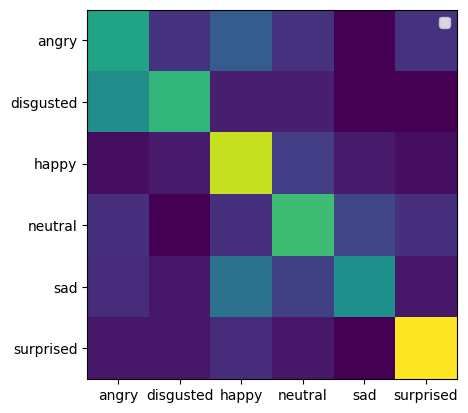

In [255]:
from typing import cast

confidences = model.predict(test_dataset)
predictions = np.argmax(confidences, axis=1)

labels = cast(list[int], list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))

cmat = sklearn.metrics.confusion_matrix(labels, predictions, normalize="true")

plt.imshow(cmat)
plt.legend()
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)

sklearn.metrics.classification_report(labels, predictions, output_dict=True, target_names=CLASS_NAMES)

In [256]:
model.save(EXPRESSION_RECOGNITION_MODEL_PATH)

C:\Users\Irsan\AppData\Local\Temp\ipykernel_19944\469801421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  accuracy_fig.show()


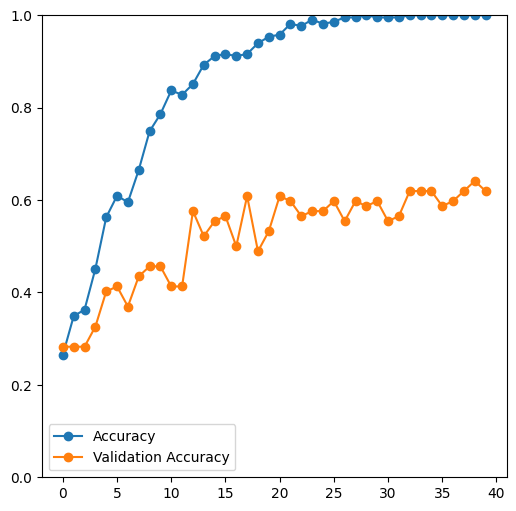

In [257]:
accuracy_fig = plt.figure(figsize=(6,6))
ax = accuracy_fig.add_subplot()
ax.plot(history.history["accuracy"], label="Accuracy", marker='o')
ax.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
ax.legend()
ax.set_ylim(0, 1)
accuracy_fig.show()